In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
! pip install keras-tuner

In [ ]:
from sklearn.model_selection import train_test_split
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers import Dense, LSTM, Dropout
from sklearn.metrics import mean_squared_error
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob
from sklearn.preprocessing import MinMaxScaler
import matplotlib.cbook as cbook
import tensorflow as tf
import kerastuner as kt
from tensorflow.keras.losses import MeanAbsoluteError
import keras
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  


In [ ]:
pd.options.display.float_format = '{:.3f}'.format

np.set_printoptions(suppress=True)

In [ ]:
path = r'/content/gdrive/MyDrive/transformed' # use your path
bus_all_files = glob.glob(path + "/bus/*.csv")
car_all_files = glob.glob(path + "/car/*.csv")
pedestrian_all_files = glob.glob(path + "/pedestrian/*.csv")
static_all_files = glob.glob(path + "/static/*.csv")
train_all_files = glob.glob(path + "/train/*.csv") 
all_files=[]
bus_all_files.sort()
all_files = all_files + bus_all_files + car_all_files + pedestrian_all_files + static_all_files + train_all_files


In [ ]:
li_train = []
for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    li_train.append(df)
frame = pd.concat(li_train, axis=0, ignore_index=True)
frame.head()

,CQI-0,CQI-1,CQI-2,CQI-3,CQI-4,DL_bitrate-0,DL_bitrate-1,DL_bitrate-2,DL_bitrate-3,DL_bitrate-4,...,SNR-1,SNR-2,SNR-3,SNR-4,UL_bitrate-0,UL_bitrate-1,UL_bitrate-2,UL_bitrate-3,UL_bitrate-4,DL_bitrate
0,7,7,10,7,7,0,0,310,3,3,...,7.000,7.000,10.000,10.000,0,0,14,7,7,1769
1,7,7,7,10,7,0,0,0,310,3,...,8.000,7.000,7.000,10.000,0,0,0,14,7,2272
2,7,7,7,7,10,0,0,0,0,310,...,8.000,8.000,7.000,7.000,0,0,0,0,14,2549
3,9,7,7,7,7,1757,0,0,0,0,...,10.000,8.000,8.000,7.000,68,0,0,0,0,2674
4,9,9,7,7,7,4216,1757,0,0,0,...,10.000,10.000,8.000,8.000,151,68,0,0,0,2393


In [ ]:

frame.shape

(173308, 46)

# Dealing with Nan Values

In [ ]:
frame.replace('-', np.NaN, inplace = True)
frame.isna().sum().sum()

1412508

In [ ]:
imputer = IterativeImputer(imputation_order='ascending',max_iter=10,random_state=42,n_nearest_features=None)
imputed_dataset = imputer.fit_transform(frame)
frame = pd.DataFrame(imputed_dataset,columns = frame.columns)
frame.isna().sum().sum()

0

In [ ]:
frame.describe()

,CQI-0,CQI-1,CQI-2,CQI-3,CQI-4,DL_bitrate-0,DL_bitrate-1,DL_bitrate-2,DL_bitrate-3,DL_bitrate-4,...,SNR-1,SNR-2,SNR-3,SNR-4,UL_bitrate-0,UL_bitrate-1,UL_bitrate-2,UL_bitrate-3,UL_bitrate-4,DL_bitrate
count,173308.000,173308.000,173308.000,173308.000,173308.000,173308.000,173308.000,173308.000,173308.000,173308.000,...,173308.000,173308.000,173308.000,173308.000,173308.000,173308.000,173308.000,173308.000,173308.000,173308.000
mean,7.803,7.762,7.774,7.758,7.767,10808.171,10810.279,10812.429,10815.209,10817.851,...,6.035,5.848,5.893,5.975,184.515,184.544,184.575,184.610,184.650,10801.786
std,2.553,2.560,2.558,2.562,2.561,14141.294,14144.785,14147.370,14151.142,14155.226,...,6.788,6.749,6.758,6.782,220.351,220.395,220.423,220.457,220.511,13662.110
min,-0.633,1.000,1.000,1.000,0.785,0.000,0.000,0.000,0.000,0.000,...,-30.000,-30.000,-30.000,-30.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,7.000,7.000,7.000,7.000,7.000,1386.000,1386.000,1386.000,1386.000,1386.000,...,2.000,2.000,2.000,2.000,32.000,32.000,32.000,32.000,32.000,1596.000
50%,7.329,7.187,7.228,7.178,7.211,5368.000,5368.000,5368.000,5368.000,5368.000,...,7.434,6.905,7.000,7.000,107.000,107.000,107.000,107.000,107.000,5611.000
75%,9.000,9.000,9.000,9.000,9.000,14774.000,14774.000,14785.000,14785.000,14785.000,...,8.000,7.589,7.850,8.000,266.000,266.000,266.000,266.000,266.000,14952.000
max,15.000,15.000,15.000,15.000,15.000,173016.000,173016.000,173016.000,173016.000,173016.000,...,33.000,33.000,33.000,33.698,4178.000,4178.000,4178.000,4178.000,4178.000,161878.000


In [ ]:
frame.isna().sum().sum()

0

In [ ]:
print(frame['DL_bitrate'].quantile(0.33))
print(frame['DL_bitrate'].quantile(0.66))

2533.0
10632.24000000002


In [ ]:
frame_low = frame[frame['DL_bitrate']<=frame['DL_bitrate'].quantile(0.33)]
frame_medium = frame[(frame['DL_bitrate']>frame['DL_bitrate'].quantile(0.33)) & (frame['DL_bitrate']<=frame['DL_bitrate'].quantile(0.66))]
frame_high = frame[frame['DL_bitrate']>frame['DL_bitrate'].quantile(0.66)]

In [ ]:
frame_low.shape

(57207, 46)

In [ ]:
frame_medium.shape

(57176, 46)

In [ ]:
frame_high.shape

(58925, 46)

In [ ]:
col_names_scaled =['CQI-0', 'CQI-1', 'CQI-2', 'CQI-3', 'CQI-4', 'DL_bitrate-0',
       'DL_bitrate-1', 'DL_bitrate-2', 'DL_bitrate-3', 'DL_bitrate-4', 'SNR-0', 'SNR-1', 'SNR-2', 'SNR-3', 'SNR-4', 'DL_bitrate']

# Random Split

## Low Throughput

In [ ]:
frame_low_train = frame_low.sample(frac = 0.7, random_state=0)
frame_low_test = frame_low.drop(frame_low_train.index)

In [ ]:
frame_low_train.head()

,CQI-0,CQI-1,CQI-2,CQI-3,CQI-4,DL_bitrate-0,DL_bitrate-1,DL_bitrate-2,DL_bitrate-3,DL_bitrate-4,...,SNR-1,SNR-2,SNR-3,SNR-4,UL_bitrate-0,UL_bitrate-1,UL_bitrate-2,UL_bitrate-3,UL_bitrate-4,DL_bitrate
163232,6.479,6.507,6.004,5.000,2.000,0.000,0.000,0.000,0.000,0.000,...,7.974,3.893,5.705,1.000,0.000,0.000,0.000,0.000,0.000,188.000
135535,7.204,7.115,7.162,7.112,7.140,223.000,223.000,235.000,223.000,503.000,...,7.635,7.008,7.139,7.380,4.000,4.000,4.000,4.000,10.000,156.000
111340,4.000,8.000,5.000,7.000,7.000,1308.000,3310.000,2393.000,693.000,335.000,...,-5.000,-1.000,-1.000,1.000,25.000,61.000,70.000,27.000,10.000,1482.000
20970,7.472,7.165,7.085,7.024,7.212,6307.000,5200.000,402.000,0.000,1521.000,...,7.522,6.997,7.185,8.123,152.000,95.000,10.000,0.000,27.000,1731.000
164942,7.036,7.140,7.174,7.111,7.238,122.000,2396.000,3020.000,857.000,857.000,...,7.849,6.904,7.547,7.810,12.000,50.000,69.000,30.000,30.000,51.000


In [ ]:
frame_low_test.head()

,CQI-0,CQI-1,CQI-2,CQI-3,CQI-4,DL_bitrate-0,DL_bitrate-1,DL_bitrate-2,DL_bitrate-3,DL_bitrate-4,...,SNR-1,SNR-2,SNR-3,SNR-4,UL_bitrate-0,UL_bitrate-1,UL_bitrate-2,UL_bitrate-3,UL_bitrate-4,DL_bitrate
4,9.000,9.000,7.000,7.000,7.000,4216.000,1757.000,0.000,0.000,0.000,...,10.000,10.000,8.000,8.000,151.000,68.000,0.000,0.000,0.000,2393.000
7,7.000,8.000,9.000,9.000,9.000,1386.000,2516.000,2874.000,4216.000,1757.000,...,10.000,10.000,10.000,10.000,26.000,47.000,53.000,151.000,68.000,2357.000
13,7.000,7.000,7.000,7.000,9.000,2169.000,3824.000,1107.000,1666.000,2807.000,...,8.000,8.000,8.000,9.000,78.000,75.000,52.000,60.000,52.000,1815.000
14,9.000,7.000,7.000,7.000,7.000,2874.000,2169.000,3824.000,1107.000,1666.000,...,8.000,8.000,8.000,8.000,54.000,78.000,75.000,52.000,60.000,1462.000
16,9.000,9.000,9.000,7.000,7.000,1543.000,2337.000,2874.000,2169.000,3824.000,...,9.000,9.000,8.000,8.000,30.000,46.000,54.000,78.000,75.000,769.000


In [ ]:
print(frame_low_train.shape)
print(frame_low_test.shape)

(40045, 46)
(17162, 46)


### With Scaling

#### MinMax Scaler

In [ ]:
df = frame_low_train[col_names_scaled]
min_max_scaler = MinMaxScaler()
# transform data
df_min_max_scaled = pd.DataFrame(min_max_scaler.fit_transform(df))

In [ ]:
X_train_min_max_scaler, X_valid_min_max_scaler, Y_train_min_max_scaler, Y_valid_min_max_scaler = train_test_split(df_min_max_scaled.iloc[:,:-1], df_min_max_scaled.iloc[:,-1:], test_size=0.3, random_state=0)
print('Train set shape', X_train_min_max_scaler.shape)
print('Validation set shape', X_valid_min_max_scaler.shape)
X_train_min_max_scaler.head()

Train set shape (28031, 15)
Validation set shape (12014, 15)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
27044,0.445,0.443,0.442,0.446,0.464,0.000,0.030,0.017,0.016,0.035,0.616,0.598,0.587,0.597,0.600
27673,0.357,0.357,0.357,0.286,0.367,0.016,0.036,0.031,0.005,0.032,0.397,0.397,0.365,0.365,0.429
30529,0.445,0.439,0.443,0.438,0.449,0.023,0.048,0.049,0.029,0.036,0.622,0.598,0.588,0.590,0.594
12916,0.500,0.429,0.357,0.286,0.367,0.019,0.008,0.020,0.008,0.006,0.397,0.397,0.397,0.413,0.413
6583,0.071,0.071,0.071,0.071,0.085,0.000,0.000,0.000,0.000,0.000,0.635,0.635,0.635,0.635,0.651


In [ ]:
X_train_min_max_series = X_train_min_max_scaler.values.reshape((X_train_min_max_scaler.shape[0], X_train_min_max_scaler.shape[1], 1))
X_valid_min_max_series = X_valid_min_max_scaler.values.reshape((X_valid_min_max_scaler.shape[0], X_valid_min_max_scaler.shape[1], 1))
print('Train set shape', X_train_min_max_series.shape)
print('Validation set shape', X_valid_min_max_series.shape)

Train set shape (28031, 15, 1)
Validation set shape (12014, 15, 1)


### Hyper Parameter Tuning using Keras Auto Tuner

In [ ]:
mae = MeanAbsoluteError()
def model_builder(hp):
  model = keras.Sequential()
  model.add(keras.layers.Flatten(input_shape=(X_train_min_max_series.shape[1], X_train_min_max_series.shape[2])))

  # Tune the number of units in the first Dense layer
  # Choose an optimal value between 32-512

  hp_units1 = hp.Int('units1', min_value=32, max_value=512, step=32)
  hp_units2 = hp.Int('units2', min_value=32, max_value=512, step=32)
  hp_units3 = hp.Int('units3', min_value=32, max_value=512, step=32)
  model.add(Dense(units=hp_units1, activation='relu'))
  model.add(Dropout(rate=hp.Float('dropout_1',min_value=0.0,max_value=0.4,default=0.25,step=0.05)))
  model.add(tf.keras.layers.Dense(units=hp_units2, activation='relu'))
  model.add(Dropout(rate=hp.Float('dropout_2',min_value=0.0,max_value=0.4,default=0.25,step=0.05)))
  model.add(tf.keras.layers.Dense(units=hp_units3, activation='relu'))

  model.add(Dropout(rate=hp.Float('dropout_3',min_value=0.0,max_value=0.4,default=0.25,step=0.05)))
  model.add(Dense(1, kernel_initializer='normal', activation='linear'))

  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),loss=mae,metrics=[mae])

  return model


In [ ]:
tuner = kt.Hyperband(model_builder,
                     objective='val_mean_absolute_error',
                     max_epochs=100,
                     factor=3,
                     directory='my_dir',
                     project_name='intro_to_kt')


In [ ]:
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=50, 
        verbose=1, mode='auto', restore_best_weights=True)

In [ ]:
tuner.search(X_train_min_max_series, Y_train_min_max_scaler, validation_data=(X_valid_min_max_series, Y_valid_min_max_scaler), epochs=100, callbacks=[monitor])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]


Trial 254 Complete [00h 03m 36s]
val_mean_absolute_error: 0.10969487577676773

Best val_mean_absolute_error So Far: 0.10867676883935928
Total elapsed time: 02h 11m 07s
INFO:tensorflow:Oracle triggered exit


In [ ]:
for h_param in [f"units{i}" for i in range(1,4)] + ['learning_rate']:
  print(h_param, tuner.get_best_hyperparameters()[0].get(h_param))

units1 224
units2 480
units3 480
learning_rate 0.0001


In [ ]:
best_model = tuner.get_best_models()[0]
best_model.build(X_train_min_max_series.shape)
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 15)                0         
                                                                 
 dense (Dense)               (None, 224)               3584      
                                                                 
 dropout (Dropout)           (None, 224)               0         
                                                                 
 dense_1 (Dense)             (None, 480)               108000    
                                                                 
 dropout_1 (Dropout)         (None, 480)               0         
                                                                 
 dense_2 (Dense)             (None, 480)               230880    
                                                                 
 dropout_2 (Dropout)         (None, 480)               0

In [ ]:
from keras.models import load_model

best_model.save('best_model.h5')  # creates a HDF5 file 'my_model.h5'
#model = load_model('my_model.h5')

In [ ]:
kt_train_pred_min_max_scaled = best_model.predict(X_train_min_max_scaler)
kt_valid_pred_min_max_scaled = best_model.predict(X_valid_min_max_scaler)
print('Train rmse:', np.sqrt(mean_squared_error(Y_train_min_max_scaler, kt_train_pred_min_max_scaled)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_valid_min_max_scaler, kt_valid_pred_min_max_scaled)))

Train rmse: 0.16850371607940728
Validation rmse: 0.1730081703936263


In [ ]:
df = frame_low_test[col_names_scaled]
df_test_scaled = pd.DataFrame(min_max_scaler.fit_transform(df))
X_test_scaled = df_test_scaled.iloc[:,:-1]
X_test_scaled.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0.616,0.571,0.429,0.429,0.429,0.068,0.028,0.000,0.000,0.000,0.635,0.635,0.645,0.623,0.597
1,0.488,0.500,0.571,0.571,0.571,0.022,0.039,0.045,0.070,0.034,0.667,0.635,0.645,0.656,0.628
2,0.488,0.429,0.429,0.429,0.571,0.035,0.060,0.017,0.028,0.055,0.603,0.603,0.613,0.623,0.612
3,0.616,0.429,0.429,0.429,0.429,0.046,0.034,0.060,0.018,0.033,0.619,0.603,0.613,0.623,0.597
4,0.616,0.571,0.571,0.429,0.429,0.025,0.037,0.045,0.036,0.075,0.635,0.619,0.629,0.623,0.597


In [ ]:
Y_test = frame_low_test.iloc[:,-1:]
Y_test.reset_index(drop=True,inplace=True)
X_pred_scaled = best_model.predict(X_test_scaled)
df_test_scaled[15]=X_pred_scaled
#Inverse Transforming the Predicted Values
df_test = pd.DataFrame(min_max_scaler.inverse_transform(df_test_scaled))
Y_pred = df_test.iloc[:,-1:]

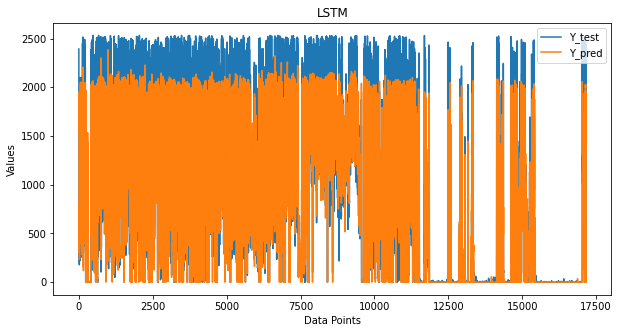

In [ ]:
fig, axes = plt.subplots(1, 1, sharex=True, sharey=True,figsize=(10,5))
ax3 = axes
ax3.plot(Y_test, label='Y_test')
ax3.plot(Y_pred, label='Y_pred')
ax3.legend(loc='best')
ax3.set_title('LSTM')
ax3.set_xlabel('Data Points')
ax3.set_ylabel('Values')
plt.show()

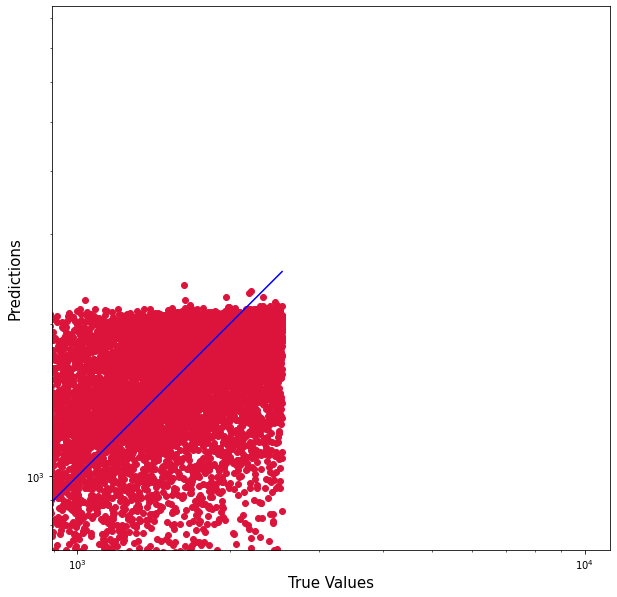

In [ ]:
plt.figure(figsize=(10,10))
plt.scatter(Y_test['DL_bitrate'], Y_pred[15], c='crimson')
plt.yscale('log')
plt.xscale('log')

p1 = max(max(Y_pred[15]), max(Y_test['DL_bitrate']))
p2 = min(min(Y_pred[15]), min(Y_test['DL_bitrate']))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

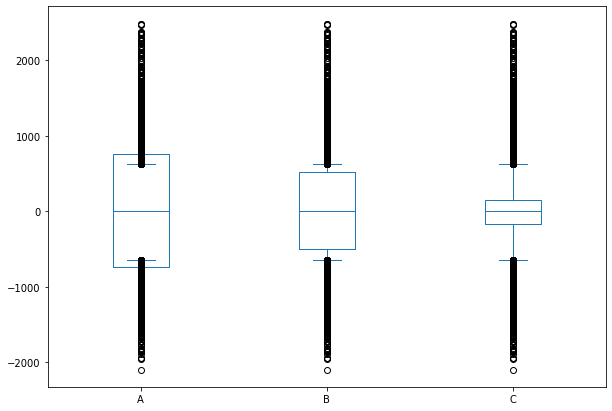

In [ ]:
import matplotlib.cbook as cbook
a=Y_test['DL_bitrate'].subtract(Y_pred[15])
stats = {}
# Compute the boxplot stats (as in the default matplotlib implementation)
stats['A'] = cbook.boxplot_stats(a, labels='A')[0]
stats['B'] = cbook.boxplot_stats(a, labels='B')[0]
stats['C'] = cbook.boxplot_stats(a, labels='C')[0]

# For box A compute the 1st and 99th percentiles
stats['A']['q1'], stats['A']['q3'] = np.percentile(a, [5, 95])
# For box B compute the 10th and 90th percentiles
stats['B']['q1'], stats['B']['q3'] = np.percentile(a, [10, 90])
# For box C compute the 25th and 75th percentiles (matplotlib default)
stats['C']['q1'], stats['C']['q3'] = np.percentile(a, [25, 75])

#fig = plt.figure(figsize =(10, 7))
fig, ax = plt.subplots(1, 1, figsize = (10,7))
# Plot boxplots from our computed statistics
bp = ax.bxp([stats['A'], stats['B'], stats['C']], positions=range(3))

# Colour the lines in the boxplot blue
for element in bp.keys():
    plt.setp(bp[element], color='C0')

In [ ]:
# calculate MAE
error = mae(Y_test, Y_pred)

# display
print("Mean absolute error : " + str(error))
print(f"Decimal Representation: {error:.20f}")

Mean absolute error : tf.Tensor(279.52606201171875, shape=(), dtype=float64)
Decimal Representation: 279.52606201171875000000


In [ ]:
# Mean Absolute Percentage Error
error = mean_absolute_percentage_error(Y_test, Y_pred)
print(error)

print(f" {error:.5f}")

2.5182799902122612e+16
 25182799902122612.00000


In [ ]:
# Relative Absolute Error
# (|y1-y2|)/(|y1_mean-y1|)
def relative_absolute_error(y_true, y_pred):
  y1=y_true.to_numpy()
  y2=y_pred.to_numpy()
  num = np.sum(np.absolute(np.array(y1) - np.array(y2)))
  deno = np.sum(np.absolute(y2-np.mean(y1)))
  return (num/deno)
relative_absolute_error(Y_test, Y_pred)

0.41206655375525864

In [ ]:
# Root Relative Squared Error
# (|y1-y2|^2)/(|y1_mean-y1|^2)
def rrse(y_true, y_pred):
  y1=y_true.to_numpy()
  y2=y_pred.to_numpy()
  num = np.sum(np.square(np.absolute(np.array(y1) - np.array(y2))))
  deno = np.sum(np.square(np.absolute(y2-np.mean(y1))))
  return (num/deno)
rrse(Y_test, Y_pred)

0.3453780777043954

# Random Split

## Medium Throughput

In [ ]:
frame_medium_train = frame_medium.sample(frac = 0.7, random_state=0)
frame_medium_test = frame_medium.drop(frame_medium_train.index)

In [ ]:
frame_medium_train.head()

,CQI-0,CQI-1,CQI-2,CQI-3,CQI-4,DL_bitrate-0,DL_bitrate-1,DL_bitrate-2,DL_bitrate-3,DL_bitrate-4,...,SNR-1,SNR-2,SNR-3,SNR-4,UL_bitrate-0,UL_bitrate-1,UL_bitrate-2,UL_bitrate-3,UL_bitrate-4,DL_bitrate
75534,7.227,7.134,7.295,7.323,7.217,2896.000,4440.000,5021.000,5424.000,4965.000,...,7.666,7.189,7.411,6.674,57.000,92.000,92.000,110.000,92.000,4336.000
104462,1.000,5.000,5.000,4.000,4.000,3187.000,4697.000,2617.000,2494.000,5625.000,...,-2.000,-2.000,-1.000,-1.000,62.000,87.000,52.000,74.000,104.000,7403.000
111095,6.000,7.000,7.000,7.000,9.000,3713.000,2885.000,2247.000,4551.000,4954.000,...,1.000,1.000,0.000,0.000,71.000,69.000,49.000,84.000,105.000,3976.000
81510,6.000,7.000,7.000,7.000,7.000,10367.000,7090.000,3947.000,12358.000,12470.000,...,-4.000,-4.000,-5.000,-5.000,165.000,117.000,97.000,197.000,203.000,9188.000
125886,10.000,10.000,9.000,9.000,9.000,3746.000,3880.000,1800.000,3377.000,3892.000,...,8.000,7.000,7.000,7.000,69.000,120.000,32.000,61.000,128.000,3126.000


In [ ]:
frame_medium_test.head()

,CQI-0,CQI-1,CQI-2,CQI-3,CQI-4,DL_bitrate-0,DL_bitrate-1,DL_bitrate-2,DL_bitrate-3,DL_bitrate-4,...,SNR-1,SNR-2,SNR-3,SNR-4,UL_bitrate-0,UL_bitrate-1,UL_bitrate-2,UL_bitrate-3,UL_bitrate-4,DL_bitrate
11,7.000,7.000,9.000,7.000,7.000,1107.000,1666.000,2807.000,2382.000,1386.000,...,8.000,9.000,9.000,12.000,52.000,60.000,52.000,45.000,26.000,2549.000
141,7.000,7.000,6.000,6.000,6.000,2516.000,2549.000,1711.000,3534.000,816.000,...,-2.000,-7.000,-7.000,-8.000,47.000,47.000,31.000,65.000,16.000,2578.000
245,9.000,6.000,6.000,6.000,9.000,1151.000,973.000,794.000,1017.000,1040.000,...,1.000,1.000,-2.000,-2.000,21.000,18.000,22.000,32.000,28.000,2972.000
246,9.000,9.000,6.000,6.000,6.000,1308.000,1151.000,973.000,794.000,1017.000,...,2.000,1.000,1.000,-2.000,25.000,21.000,18.000,22.000,32.000,3777.000
248,9.000,9.000,9.000,9.000,6.000,1532.000,1644.000,1308.000,1151.000,973.000,...,4.000,2.000,2.000,1.000,29.000,31.000,25.000,21.000,18.000,5540.000


### With Scaling

#### MinMax Scaler

In [ ]:
df = frame_medium_train[col_names_scaled]
min_max_scaler = MinMaxScaler()
# transform data
df_min_max_scaled = pd.DataFrame(min_max_scaler.fit_transform(df))

In [ ]:
X_train_min_max_scaler, X_valid_min_max_scaler, Y_train_min_max_scaler, Y_valid_min_max_scaler = train_test_split(df_min_max_scaled.iloc[:,:-1], df_min_max_scaled.iloc[:,-1:], test_size=0.3, random_state=0)
print('Train set shape', X_train_min_max_scaler.shape)
print('Validation set shape', X_valid_min_max_scaler.shape)
X_train_min_max_scaler.head()

Train set shape (28016, 15)
Validation set shape (12007, 15)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
1037,0.500,0.500,0.500,0.500,0.500,0.037,0.035,0.030,0.049,0.053,0.516,0.519,0.475,0.464,0.557
12971,0.469,0.454,0.449,0.437,0.433,0.040,0.044,0.042,0.032,0.019,0.605,0.579,0.521,0.520,0.598
35544,0.714,0.500,0.071,0.071,0.071,0.066,0.087,0.050,0.153,0.115,0.516,0.519,0.203,0.187,0.475
10438,0.714,0.714,0.714,0.714,0.714,0.038,0.070,0.060,0.066,0.058,0.555,0.557,0.533,0.524,0.607
35646,0.461,0.443,0.455,0.454,0.442,0.075,0.071,0.079,0.139,0.089,0.598,0.572,0.539,0.525,0.612


In [ ]:
X_train_min_max_series = X_train_min_max_scaler.values.reshape((X_train_min_max_scaler.shape[0], X_train_min_max_scaler.shape[1], 1))
X_valid_min_max_series = X_valid_min_max_scaler.values.reshape((X_valid_min_max_scaler.shape[0], X_valid_min_max_scaler.shape[1], 1))
print('Train set shape', X_train_min_max_series.shape)
print('Validation set shape', X_valid_min_max_series.shape)

Train set shape (28016, 15, 1)
Validation set shape (12007, 15, 1)


### Hyper Parameter Tuning using Keras Auto Tuner

In [ ]:
mae = MeanAbsoluteError()
def model_builder(hp):
  model = keras.Sequential()
  model.add(keras.layers.Flatten(input_shape=(X_train_min_max_series.shape[1], X_train_min_max_series.shape[2])))

  # Tune the number of units in the first Dense layer
  # Choose an optimal value between 32-512

  hp_units1 = hp.Int('units1', min_value=32, max_value=512, step=32)
  hp_units2 = hp.Int('units2', min_value=32, max_value=512, step=32)
  hp_units3 = hp.Int('units3', min_value=32, max_value=512, step=32)
  model.add(Dense(units=hp_units1, activation='relu'))
  model.add(Dropout(rate=hp.Float('dropout_1',min_value=0.0,max_value=0.4,default=0.25,step=0.05)))
  model.add(tf.keras.layers.Dense(units=hp_units2, activation='relu'))
  model.add(Dropout(rate=hp.Float('dropout_2',min_value=0.0,max_value=0.4,default=0.25,step=0.05)))
  model.add(tf.keras.layers.Dense(units=hp_units3, activation='relu'))

  model.add(Dropout(rate=hp.Float('dropout_3',min_value=0.0,max_value=0.4,default=0.25,step=0.05)))
  model.add(Dense(1, kernel_initializer='normal', activation='linear'))

  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),loss=mae,metrics=[mae])

  return model


In [ ]:
tuner = kt.Hyperband(model_builder,
                     objective='val_mean_absolute_error',
                     max_epochs=100,
                     factor=3,
                     directory='my_dir',
                     project_name='intro_to_kt1')


In [ ]:
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=50, 
        verbose=1, mode='auto', restore_best_weights=True)

In [ ]:
tuner.search(X_train_min_max_series, Y_train_min_max_scaler, validation_data=(X_valid_min_max_series, Y_valid_min_max_scaler), epochs=100, callbacks=[monitor])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]


Trial 254 Complete [00h 02m 44s]
val_mean_absolute_error: 0.1591060310602188

Best val_mean_absolute_error So Far: 0.15816843509674072
Total elapsed time: 02h 09m 25s
INFO:tensorflow:Oracle triggered exit


In [ ]:
for h_param in [f"units{i}" for i in range(1,4)] + ['learning_rate']:
  print(h_param, tuner.get_best_hyperparameters()[0].get(h_param))

units1 320
units2 352
units3 352
learning_rate 0.0001


In [ ]:
best_model = tuner.get_best_models()[0]
best_model.build(X_train_min_max_series.shape)
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 15)                0         
                                                                 
 dense (Dense)               (None, 320)               5120      
                                                                 
 dropout (Dropout)           (None, 320)               0         
                                                                 
 dense_1 (Dense)             (None, 352)               112992    
                                                                 
 dropout_1 (Dropout)         (None, 352)               0         
                                                                 
 dense_2 (Dense)             (None, 352)               124256    
                                                                 
 dropout_2 (Dropout)         (None, 352)               0

In [ ]:
from keras.models import load_model

best_model.save('best_model.h5')  # creates a HDF5 file 'my_model.h5'
#model = load_model('my_model.h5')

In [ ]:
kt_train_pred_min_max_scaled = best_model.predict(X_train_min_max_scaler)
kt_valid_pred_min_max_scaled = best_model.predict(X_valid_min_max_scaler)
print('Train rmse:', np.sqrt(mean_squared_error(Y_train_min_max_scaler, kt_train_pred_min_max_scaled)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_valid_min_max_scaler, kt_valid_pred_min_max_scaled)))

Train rmse: 0.20352372240450853
Validation rmse: 0.20902099394667684


In [ ]:
df = frame_medium_test[col_names_scaled]
df_test_scaled = pd.DataFrame(min_max_scaler.fit_transform(df))
X_test_scaled = df_test_scaled.iloc[:,:-1]
X_test_scaled.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0.429,0.429,0.571,0.429,0.429,0.022,0.017,0.029,0.025,0.017,0.523,0.500,0.532,0.571,0.641
1,0.429,0.429,0.357,0.357,0.357,0.050,0.026,0.018,0.037,0.010,0.295,0.283,0.191,0.245,0.242
2,0.571,0.357,0.357,0.357,0.571,0.023,0.010,0.008,0.011,0.013,0.386,0.348,0.362,0.347,0.361
3,0.571,0.571,0.357,0.357,0.357,0.026,0.012,0.010,0.008,0.013,0.386,0.370,0.362,0.408,0.361
4,0.571,0.571,0.571,0.571,0.357,0.030,0.017,0.013,0.012,0.012,0.432,0.413,0.383,0.429,0.421


In [ ]:
Y_test = frame_medium_test.iloc[:,-1:]
Y_test.reset_index(drop=True,inplace=True)
X_pred_scaled = best_model.predict(X_test_scaled)
df_test_scaled[15]=X_pred_scaled
#Inverse Transforming the Predicted Values
df_test = pd.DataFrame(min_max_scaler.inverse_transform(df_test_scaled))
Y_pred = df_test.iloc[:,-1:]

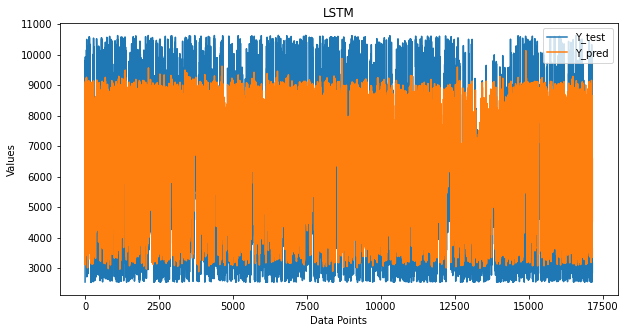

In [ ]:
fig, axes = plt.subplots(1, 1, sharex=True, sharey=True,figsize=(10,5))
ax3 = axes
ax3.plot(Y_test, label='Y_test')
ax3.plot(Y_pred, label='Y_pred')
ax3.legend(loc='best')
ax3.set_title('LSTM')
ax3.set_xlabel('Data Points')
ax3.set_ylabel('Values')
plt.show()

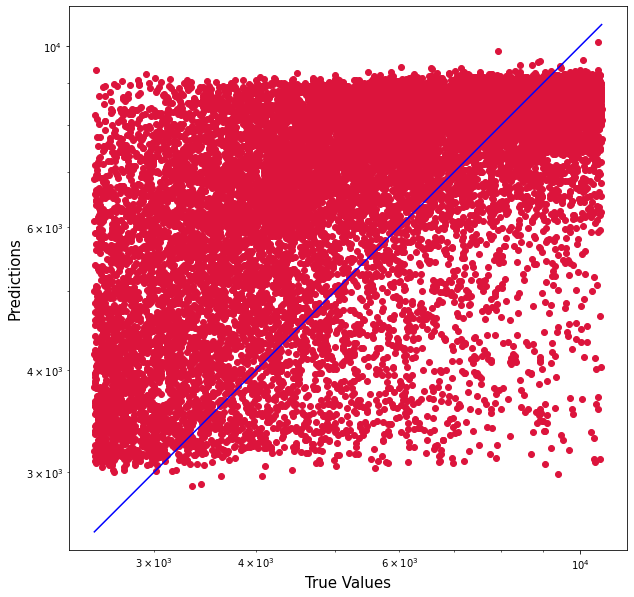

In [ ]:
plt.figure(figsize=(10,10))
plt.scatter(Y_test['DL_bitrate'], Y_pred[15], c='crimson')
plt.yscale('log')
plt.xscale('log')

p1 = max(max(Y_pred[15]), max(Y_test['DL_bitrate']))
p2 = min(min(Y_pred[15]), min(Y_test['DL_bitrate']))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

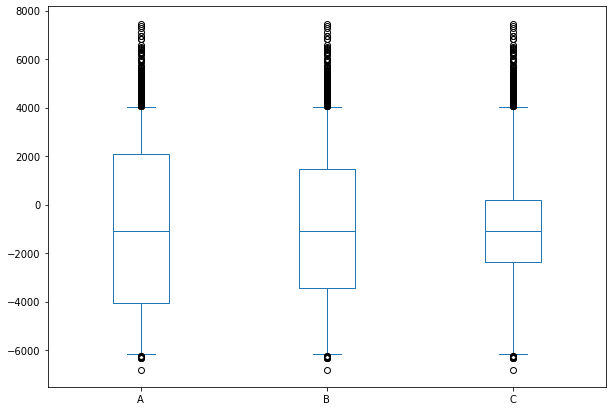

In [ ]:
import matplotlib.cbook as cbook
a=Y_test['DL_bitrate'].subtract(Y_pred[15])
stats = {}
# Compute the boxplot stats (as in the default matplotlib implementation)
stats['A'] = cbook.boxplot_stats(a, labels='A')[0]
stats['B'] = cbook.boxplot_stats(a, labels='B')[0]
stats['C'] = cbook.boxplot_stats(a, labels='C')[0]

# For box A compute the 1st and 99th percentiles
stats['A']['q1'], stats['A']['q3'] = np.percentile(a, [5, 95])
# For box B compute the 10th and 90th percentiles
stats['B']['q1'], stats['B']['q3'] = np.percentile(a, [10, 90])
# For box C compute the 25th and 75th percentiles (matplotlib default)
stats['C']['q1'], stats['C']['q3'] = np.percentile(a, [25, 75])

#fig = plt.figure(figsize =(10, 7))
fig, ax = plt.subplots(1, 1, figsize = (10,7))
# Plot boxplots from our computed statistics
bp = ax.bxp([stats['A'], stats['B'], stats['C']], positions=range(3))

# Colour the lines in the boxplot blue
for element in bp.keys():
    plt.setp(bp[element], color='C0')

In [ ]:
Y_pred

,15
0,3426.432
1,3803.714
2,3199.331
3,3348.600
4,3110.134
...,...
17148,4208.365
17149,4862.608
17150,5036.277
17151,6604.805


In [ ]:
# calculate MAE
error = mae(Y_test, Y_pred)

# display
print("Mean absolute error : " + str(error))
print(f"Decimal Representation: {error:.20f}")

Mean absolute error : tf.Tensor(1764.3834228515625, shape=(), dtype=float64)
Decimal Representation: 1764.38342285156250000000


In [ ]:
# Mean Absolute Percentage Error
error = mean_absolute_percentage_error(Y_test, Y_pred)
print(error)

print(f" {error:.5f}")

0.38395275956206304
 0.38395


In [ ]:
# Relative Absolute Error
# (|y1-y2|)/(|y1_mean-y1|)
def relative_absolute_error(y_true, y_pred):
  y1=y_true.to_numpy()
  y2=y_pred.to_numpy()
  num = np.sum(np.absolute(np.array(y1) - np.array(y2)))
  deno = np.sum(np.absolute(y2-np.mean(y1)))
  return (num/deno)
relative_absolute_error(Y_test, Y_pred)

0.9617173424500024

In [ ]:
# Root Relative Squared Error
# (|y1-y2|^2)/(|y1_mean-y1|^2)
def rrse(y_true, y_pred):
  y1=y_true.to_numpy()
  y2=y_pred.to_numpy()
  num = np.sum(np.square(np.absolute(np.array(y1) - np.array(y2))))
  deno = np.sum(np.square(np.absolute(y2-np.mean(y1))))
  return (num/deno)
rrse(Y_test, Y_pred)

1.122840425045627

## High Throughput

In [ ]:
frame_high_train = frame_high.sample(frac = 0.7, random_state=0)
frame_high_test = frame_high.drop(frame_high_train.index)

In [ ]:
frame_high_train.head()

,CQI-0,CQI-1,CQI-2,CQI-3,CQI-4,DL_bitrate-0,DL_bitrate-1,DL_bitrate-2,DL_bitrate-3,DL_bitrate-4,...,SNR-1,SNR-2,SNR-3,SNR-4,UL_bitrate-0,UL_bitrate-1,UL_bitrate-2,UL_bitrate-3,UL_bitrate-4,DL_bitrate
80132,6.000,8.000,8.000,9.000,9.000,27435.000,45004.000,39066.000,22390.000,34481.000,...,6.000,4.000,4.000,4.000,507.000,729.000,767.000,416.000,605.000,30339.000
103609,15.000,15.000,15.000,11.000,12.000,8689.000,17894.000,44545.000,23396.000,22267.000,...,13.000,14.000,13.000,14.000,160.000,327.000,836.000,404.000,406.000,19464.000
60319,7.000,7.000,7.000,7.000,7.000,28060.000,32635.000,29715.000,28408.000,32545.000,...,3.000,5.000,5.000,4.000,372.000,465.000,443.000,439.000,453.000,24354.000
9259,8.000,8.000,8.000,8.000,8.000,18431.000,22423.000,22468.000,29906.000,22032.000,...,7.000,7.000,5.000,5.000,272.000,394.000,315.000,523.000,259.000,19775.000
18786,12.000,12.000,12.000,12.000,12.000,15344.000,14919.000,16664.000,17245.000,16328.000,...,16.000,16.000,16.000,16.000,280.000,306.000,303.000,304.000,288.000,16952.000


In [ ]:
frame_high_test.head()

,CQI-0,CQI-1,CQI-2,CQI-3,CQI-4,DL_bitrate-0,DL_bitrate-1,DL_bitrate-2,DL_bitrate-3,DL_bitrate-4,...,SNR-1,SNR-2,SNR-3,SNR-4,UL_bitrate-0,UL_bitrate-1,UL_bitrate-2,UL_bitrate-3,UL_bitrate-4,DL_bitrate
353,10.000,10.000,9.000,9.000,8.000,5424.000,5323.000,4428.000,3970.000,4518.000,...,5.000,5.000,5.000,5.000,137.000,99.000,96.000,87.000,84.000,11845.000
371,10.000,10.000,2.000,6.000,6.000,7538.000,7538.000,7538.000,6374.000,8097.000,...,7.000,1.000,1.000,1.000,139.000,139.000,139.000,132.000,172.000,14795.000
376,10.000,15.000,10.000,15.000,12.000,24481.000,16652.000,12212.000,10859.000,9774.000,...,18.000,13.000,13.000,7.000,442.000,297.000,228.000,198.000,181.000,44632.000
377,10.000,10.000,15.000,10.000,15.000,53739.000,24481.000,16652.000,12212.000,10859.000,...,18.000,18.000,13.000,13.000,1012.000,442.000,297.000,228.000,198.000,38698.000
379,2.000,2.000,10.000,10.000,15.000,56646.000,32142.000,53739.000,24481.000,16652.000,...,14.000,14.000,18.000,18.000,1002.000,582.000,1012.000,442.000,297.000,31345.000


### With Scaling

#### MinMax Scaler

In [ ]:
df = frame_high_train[col_names_scaled]
min_max_scaler = MinMaxScaler()
# transform data
df_min_max_scaled = pd.DataFrame(min_max_scaler.fit_transform(df))

In [ ]:
X_train_min_max_scaler, X_valid_min_max_scaler, Y_train_min_max_scaler, Y_valid_min_max_scaler = train_test_split(df_min_max_scaled.iloc[:,:-1], df_min_max_scaled.iloc[:,-1:], test_size=0.3, random_state=0)
print('Train set shape', X_train_min_max_scaler.shape)
print('Validation set shape', X_valid_min_max_scaler.shape)
X_train_min_max_scaler.head()

Train set shape (28873, 15)
Validation set shape (12375, 15)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
20603,0.714,0.786,0.929,0.929,1.000,0.200,0.147,0.180,0.173,0.175,0.750,0.833,0.833,0.872,0.875
37976,1.000,1.000,0.786,0.786,1.000,0.098,0.096,0.106,0.095,0.153,0.812,0.812,0.833,0.830,0.875
31297,0.643,0.643,0.571,0.643,0.500,0.483,0.355,0.382,0.389,0.477,0.625,0.625,0.625,0.574,0.583
34516,0.469,0.450,0.446,0.450,0.447,0.068,0.074,0.055,0.079,0.063,0.530,0.492,0.481,0.473,0.489
32460,0.500,0.357,0.429,0.429,0.286,0.121,0.086,0.065,0.036,0.042,0.438,0.312,0.312,0.426,0.438


In [ ]:
X_train_min_max_series = X_train_min_max_scaler.values.reshape((X_train_min_max_scaler.shape[0], X_train_min_max_scaler.shape[1], 1))
X_valid_min_max_series = X_valid_min_max_scaler.values.reshape((X_valid_min_max_scaler.shape[0], X_valid_min_max_scaler.shape[1], 1))
print('Train set shape', X_train_min_max_series.shape)
print('Validation set shape', X_valid_min_max_series.shape)

Train set shape (28873, 15, 1)
Validation set shape (12375, 15, 1)


### Hyper Parameter Tuning using Keras Auto Tuner

In [ ]:
mae = MeanAbsoluteError()
def model_builder(hp):
  model = keras.Sequential()
  model.add(keras.layers.Flatten(input_shape=(X_train_min_max_series.shape[1], X_train_min_max_series.shape[2])))

  # Tune the number of units in the first Dense layer
  # Choose an optimal value between 32-512

  hp_units1 = hp.Int('units1', min_value=32, max_value=512, step=32)
  hp_units2 = hp.Int('units2', min_value=32, max_value=512, step=32)
  hp_units3 = hp.Int('units3', min_value=32, max_value=512, step=32)
  model.add(Dense(units=hp_units1, activation='relu'))
  model.add(Dropout(rate=hp.Float('dropout_1',min_value=0.0,max_value=0.4,default=0.25,step=0.05)))
  model.add(tf.keras.layers.Dense(units=hp_units2, activation='relu'))
  model.add(Dropout(rate=hp.Float('dropout_2',min_value=0.0,max_value=0.4,default=0.25,step=0.05)))
  model.add(tf.keras.layers.Dense(units=hp_units3, activation='relu'))

  model.add(Dropout(rate=hp.Float('dropout_3',min_value=0.0,max_value=0.4,default=0.25,step=0.05)))
  model.add(Dense(1, kernel_initializer='normal', activation='linear'))

  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),loss=mae,metrics=[mae])

  return model


In [ ]:
tuner = kt.Hyperband(model_builder,
                     objective='val_mean_absolute_error',
                     max_epochs=100,
                     factor=3,
                     directory='my_dir',
                     project_name='intro_to_kt2')


In [ ]:
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=50, 
        verbose=1, mode='auto', restore_best_weights=True)

In [ ]:
tuner.search(X_train_min_max_series, Y_train_min_max_scaler, validation_data=(X_valid_min_max_series, Y_valid_min_max_scaler), epochs=100, callbacks=[monitor])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]


Trial 254 Complete [00h 04m 18s]
val_mean_absolute_error: 0.035421308130025864

Best val_mean_absolute_error So Far: 0.031076865270733833
Total elapsed time: 02h 06m 33s
INFO:tensorflow:Oracle triggered exit


In [ ]:
for h_param in [f"units{i}" for i in range(1,4)] + ['learning_rate']:
  print(h_param, tuner.get_best_hyperparameters()[0].get(h_param))

units1 192
units2 160
units3 96
learning_rate 0.0001


In [ ]:
best_model = tuner.get_best_models()[0]
best_model.build(X_train_min_max_series.shape)
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 15)                0         
                                                                 
 dense (Dense)               (None, 192)               3072      
                                                                 
 dropout (Dropout)           (None, 192)               0         
                                                                 
 dense_1 (Dense)             (None, 160)               30880     
                                                                 
 dropout_1 (Dropout)         (None, 160)               0         
                                                                 
 dense_2 (Dense)             (None, 96)                15456     
                                                                 
 dropout_2 (Dropout)         (None, 96)                0

In [ ]:
from keras.models import load_model

best_model.save('best_model.h5')  # creates a HDF5 file 'my_model.h5'
#model = load_model('my_model.h5')

In [ ]:
kt_train_pred_min_max_scaled = best_model.predict(X_train_min_max_scaler)
kt_valid_pred_min_max_scaled = best_model.predict(X_valid_min_max_scaler)
print('Train rmse:', np.sqrt(mean_squared_error(Y_train_min_max_scaler, kt_train_pred_min_max_scaled)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_valid_min_max_scaler, kt_valid_pred_min_max_scaled)))

Train rmse: 0.04632779731856946
Validation rmse: 0.047434002902045996


In [ ]:
df = frame_high_test[col_names_scaled]
df_test_scaled = pd.DataFrame(min_max_scaler.fit_transform(df))
X_test_scaled = df_test_scaled.iloc[:,:-1]
X_test_scaled.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0.643,0.643,0.571,0.571,0.500,0.031,0.033,0.028,0.024,0.028,0.444,0.413,0.438,0.438,0.438
1,0.643,0.643,0.071,0.357,0.357,0.044,0.047,0.047,0.038,0.050,0.444,0.457,0.354,0.354,0.354
2,0.643,1.000,0.643,1.000,0.786,0.141,0.104,0.076,0.065,0.060,0.689,0.696,0.604,0.604,0.479
3,0.643,0.643,1.000,0.643,1.000,0.311,0.152,0.104,0.073,0.067,0.600,0.696,0.708,0.604,0.604
4,0.071,0.071,0.643,0.643,1.000,0.327,0.200,0.335,0.147,0.103,0.489,0.609,0.625,0.708,0.708


In [ ]:
Y_test = frame_high_test.iloc[:,-1:]
Y_test.reset_index(drop=True,inplace=True)
X_pred_scaled = best_model.predict(X_test_scaled)
df_test_scaled[15]=X_pred_scaled
#Inverse Transforming the Predicted Values
df_test = pd.DataFrame(min_max_scaler.inverse_transform(df_test_scaled))
Y_pred = df_test.iloc[:,-1:]

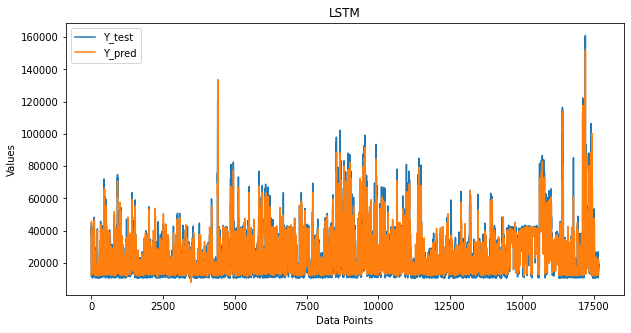

In [ ]:
fig, axes = plt.subplots(1, 1, sharex=True, sharey=True,figsize=(10,5))
ax3 = axes
ax3.plot(Y_test, label='Y_test')
ax3.plot(Y_pred, label='Y_pred')
ax3.legend(loc='best')
ax3.set_title('LSTM')
ax3.set_xlabel('Data Points')
ax3.set_ylabel('Values')
plt.show()

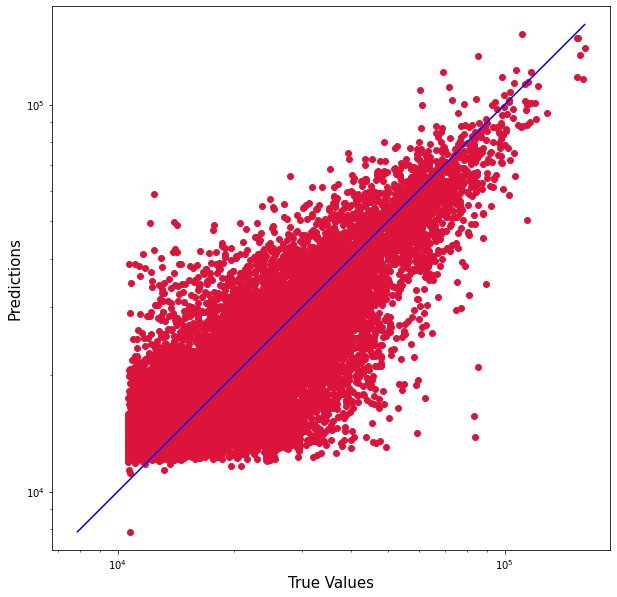

In [ ]:
plt.figure(figsize=(10,10))
plt.scatter(Y_test['DL_bitrate'], Y_pred[15], c='crimson')
plt.yscale('log')
plt.xscale('log')

p1 = max(max(Y_pred[15]), max(Y_test['DL_bitrate']))
p2 = min(min(Y_pred[15]), min(Y_test['DL_bitrate']))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

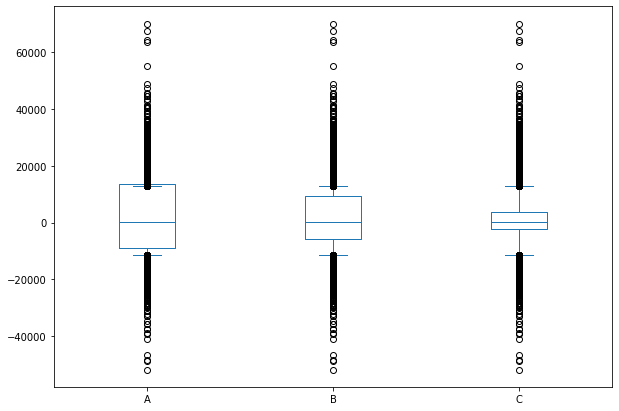

In [ ]:
import matplotlib.cbook as cbook
a=Y_test['DL_bitrate'].subtract(Y_pred[15])
stats = {}
# Compute the boxplot stats (as in the default matplotlib implementation)
stats['A'] = cbook.boxplot_stats(a, labels='A')[0]
stats['B'] = cbook.boxplot_stats(a, labels='B')[0]
stats['C'] = cbook.boxplot_stats(a, labels='C')[0]

# For box A compute the 1st and 99th percentiles
stats['A']['q1'], stats['A']['q3'] = np.percentile(a, [5, 95])
# For box B compute the 10th and 90th percentiles
stats['B']['q1'], stats['B']['q3'] = np.percentile(a, [10, 90])
# For box C compute the 25th and 75th percentiles (matplotlib default)
stats['C']['q1'], stats['C']['q3'] = np.percentile(a, [25, 75])

#fig = plt.figure(figsize =(10, 7))
fig, ax = plt.subplots(1, 1, figsize = (10,7))
# Plot boxplots from our computed statistics
bp = ax.bxp([stats['A'], stats['B'], stats['C']], positions=range(3))

# Colour the lines in the boxplot blue
for element in bp.keys():
    plt.setp(bp[element], color='C0')

In [ ]:
Y_pred

,15
0,13228.691
1,12515.579
2,20688.987
3,35503.148
4,45662.271
...,...
17672,18829.979
17673,17572.197
17674,17787.773
17675,15661.773


In [ ]:
# calculate MAE
error = mae(Y_test, Y_pred)

# display
print("Mean absolute error : " + str(error))
print(f"Decimal Representation: {error:.20f}")

Mean absolute error : tf.Tensor(4810.3173828125, shape=(), dtype=float64)
Decimal Representation: 4810.31738281250000000000


In [ ]:
# Mean Absolute Percentage Error
error = mean_absolute_percentage_error(Y_test, Y_pred)
print(error)

print(f" {error:.5f}")

0.19439607691963312
 0.19440


In [ ]:
# Relative Absolute Error
# (|y1-y2|)/(|y1_mean-y1|)
def relative_absolute_error(y_true, y_pred):
  y1=y_true.to_numpy()
  y2=y_pred.to_numpy()
  num = np.sum(np.absolute(np.array(y1) - np.array(y2)))
  deno = np.sum(np.absolute(y2-np.mean(y1)))
  return (num/deno)
relative_absolute_error(Y_test, Y_pred)

0.4691564365655328

In [ ]:
# Root Relative Squared Error
# (|y1-y2|^2)/(|y1_mean-y1|^2)
def rrse(y_true, y_pred):
  y1=y_true.to_numpy()
  y2=y_pred.to_numpy()
  num = np.sum(np.square(np.absolute(np.array(y1) - np.array(y2))))
  deno = np.sum(np.square(np.absolute(y2-np.mean(y1))))
  return (num/deno)
rrse(Y_test, Y_pred)

0.2996054853153792

# Without Throughput Split

In [ ]:
frame.shape

(173308, 46)

In [ ]:
frame_train = frame.sample(frac = 0.7, random_state=0)
frame_test = frame.drop(frame_train.index)

In [ ]:
frame_train.head()

,CQI-0,CQI-1,CQI-2,CQI-3,CQI-4,DL_bitrate-0,DL_bitrate-1,DL_bitrate-2,DL_bitrate-3,DL_bitrate-4,...,SNR-1,SNR-2,SNR-3,SNR-4,UL_bitrate-0,UL_bitrate-1,UL_bitrate-2,UL_bitrate-3,UL_bitrate-4,DL_bitrate
49904,10.000,9.000,9.000,8.000,12.000,47039.000,38774.000,42420.000,53247.000,41772.000,...,11.000,11.000,14.000,14.000,547.000,413.000,460.000,532.000,369.000,25897.000
10432,11.000,11.000,10.000,11.000,12.000,46245.000,48628.000,53884.000,53314.000,53146.000,...,15.000,14.000,14.000,14.000,913.000,944.000,1065.000,1037.000,1050.000,48703.000
111290,8.000,8.000,5.000,5.000,9.000,9025.000,4395.000,5144.000,6095.000,9159.000,...,2.000,6.000,6.000,7.000,228.000,151.000,234.000,102.000,169.000,3891.000
165744,7.355,7.170,7.048,7.027,7.117,324.000,525.000,525.000,570.000,190.000,...,7.285,6.674,7.119,7.266,7.000,9.000,10.000,10.000,4.000,247.000
48759,5.000,5.000,5.000,5.000,5.000,223.000,145.000,402.000,771.000,749.000,...,-8.000,-8.000,-6.000,-6.000,6.000,3.000,6.000,14.000,17.000,71.000


In [ ]:
frame_test.head()

,CQI-0,CQI-1,CQI-2,CQI-3,CQI-4,DL_bitrate-0,DL_bitrate-1,DL_bitrate-2,DL_bitrate-3,DL_bitrate-4,...,SNR-1,SNR-2,SNR-3,SNR-4,UL_bitrate-0,UL_bitrate-1,UL_bitrate-2,UL_bitrate-3,UL_bitrate-4,DL_bitrate
2,7.000,7.000,7.000,7.000,10.000,0.000,0.000,0.000,0.000,310.000,...,8.000,8.000,7.000,7.000,0.000,0.000,0.000,0.000,14.000,2549.000
4,9.000,9.000,7.000,7.000,7.000,4216.000,1757.000,0.000,0.000,0.000,...,10.000,10.000,8.000,8.000,151.000,68.000,0.000,0.000,0.000,2393.000
5,9.000,9.000,9.000,7.000,7.000,2874.000,4216.000,1757.000,0.000,0.000,...,10.000,10.000,10.000,8.000,53.000,151.000,68.000,0.000,0.000,2151.000
10,7.000,9.000,7.000,7.000,8.000,1666.000,2807.000,2382.000,1386.000,2516.000,...,9.000,9.000,12.000,10.000,60.000,52.000,45.000,26.000,47.000,2462.000
21,7.000,9.000,9.000,9.000,9.000,100.000,313.000,1107.000,156.000,2169.000,...,7.000,9.000,9.000,10.000,5.000,12.000,30.000,5.000,69.000,650.000


## MinMax Scaler

In [ ]:
df = frame_train[col_names_scaled]
min_max_scaler = MinMaxScaler()
# transform data
df_min_max_scaled = pd.DataFrame(min_max_scaler.fit_transform(df))

In [ ]:
X_train_min_max_scaler, X_valid_min_max_scaler, Y_train_min_max_scaler, Y_valid_min_max_scaler = train_test_split(df_min_max_scaled.iloc[:,:15], df_min_max_scaled.iloc[:,-1:], test_size=0.3, random_state=0)
print('Train set shape', X_train_min_max_scaler.shape)
print('Validation set shape', X_valid_min_max_scaler.shape)
X_train_min_max_scaler.head()

Train set shape (84921, 15)
Validation set shape (36395, 15)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
47723,0.424,0.357,0.286,0.357,0.367,0.080,0.052,0.061,0.083,0.087,0.413,0.460,0.460,0.460,0.455
50990,0.530,0.454,0.446,0.449,0.468,0.088,0.090,0.079,0.078,0.098,0.625,0.600,0.588,0.593,0.589
24873,0.517,0.466,0.461,0.447,0.461,0.083,0.117,0.120,0.097,0.097,0.627,0.603,0.588,0.591,0.589
41093,0.488,0.286,0.429,0.286,0.297,0.032,0.018,0.020,0.045,0.038,0.444,0.460,0.460,0.587,0.581
60737,0.552,0.500,0.500,0.500,0.508,0.020,0.017,0.025,0.029,0.027,0.556,0.540,0.540,0.540,0.534


In [ ]:
X_train_min_max_series = X_train_min_max_scaler.values.reshape((X_train_min_max_scaler.shape[0], X_train_min_max_scaler.shape[1], 1))
X_valid_min_max_series = X_valid_min_max_scaler.values.reshape((X_valid_min_max_scaler.shape[0], X_valid_min_max_scaler.shape[1], 1))
print('Train set shape', X_train_min_max_series.shape)
print('Validation set shape', X_valid_min_max_series.shape)

Train set shape (84921, 15, 1)
Validation set shape (36395, 15, 1)


### Hyper Parameter Tuning using Keras Auto Tuner

In [ ]:
mae = MeanAbsoluteError()
def model_builder(hp):
  model = keras.Sequential()
  model.add(keras.layers.Flatten(input_shape=(X_train_min_max_series.shape[1], X_train_min_max_series.shape[2])))

  # Tune the number of units in the first Dense layer
  # Choose an optimal value between 32-512

  hp_units1 = hp.Int('units1', min_value=32, max_value=512, step=32)
  hp_units2 = hp.Int('units2', min_value=32, max_value=512, step=32)
  hp_units3 = hp.Int('units3', min_value=32, max_value=512, step=32)
  model.add(Dense(units=hp_units1, activation='relu'))
  model.add(Dropout(rate=hp.Float('dropout_1',min_value=0.0,max_value=0.4,default=0.25,step=0.05)))
  model.add(tf.keras.layers.Dense(units=hp_units2, activation='relu'))
  model.add(Dropout(rate=hp.Float('dropout_2',min_value=0.0,max_value=0.4,default=0.25,step=0.05)))
  model.add(tf.keras.layers.Dense(units=hp_units3, activation='relu'))

  model.add(Dropout(rate=hp.Float('dropout_3',min_value=0.0,max_value=0.4,default=0.25,step=0.05)))
  model.add(Dense(1, kernel_initializer='normal', activation='linear'))

  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),loss=mae,metrics=[mae])

  return model


In [ ]:
tuner = kt.Hyperband(model_builder,
                     objective='val_mean_absolute_error',
                     max_epochs=100,
                     factor=3,
                     directory='my_dir',
                     project_name='intro_to_kt3')


In [ ]:
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=50, 
        verbose=1, mode='auto', restore_best_weights=True)

In [ ]:
tuner.search(X_train_min_max_series, Y_train_min_max_scaler, validation_data=(X_valid_min_max_series, Y_valid_min_max_scaler), epochs=100, callbacks=[monitor])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]


Trial 254 Complete [00h 07m 20s]
val_mean_absolute_error: 0.02110341563820839

Best val_mean_absolute_error So Far: 0.016260817646980286
Total elapsed time: 05h 33m 18s
INFO:tensorflow:Oracle triggered exit


In [ ]:
for h_param in [f"units{i}" for i in range(1,4)] + ['learning_rate']:
  print(h_param, tuner.get_best_hyperparameters()[0].get(h_param))

units1 448
units2 416
units3 192
learning_rate 0.0001


In [ ]:
best_model = tuner.get_best_models()[0]
best_model.build(X_train_min_max_series.shape)
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 15)                0         
                                                                 
 dense (Dense)               (None, 448)               7168      
                                                                 
 dropout (Dropout)           (None, 448)               0         
                                                                 
 dense_1 (Dense)             (None, 416)               186784    
                                                                 
 dropout_1 (Dropout)         (None, 416)               0         
                                                                 
 dense_2 (Dense)             (None, 192)               80064     
                                                                 
 dropout_2 (Dropout)         (None, 192)               0

In [ ]:
from keras.models import load_model

best_model.save('best_model.h5')  # creates a HDF5 file 'my_model.h5'
#model = load_model('my_model.h5')

In [ ]:
kt_train_pred_min_max_scaled = best_model.predict(X_train_min_max_scaler)
kt_valid_pred_min_max_scaled = best_model.predict(X_valid_min_max_scaler)
print('Train rmse:', np.sqrt(mean_squared_error(Y_train_min_max_scaler, kt_train_pred_min_max_scaled)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_valid_min_max_scaler, kt_valid_pred_min_max_scaled)))

Train rmse: 0.029601126152437637
Validation rmse: 0.030257874092832756


In [ ]:
df = frame_test[col_names_scaled]
df_test_scaled = pd.DataFrame(min_max_scaler.fit_transform(df))
X_test_scaled = df_test_scaled.iloc[:,:-1]
X_test_scaled.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0.429,0.429,0.429,0.429,0.643,0.000,0.000,0.000,0.000,0.002,0.645,0.623,0.603,0.587,0.597
1,0.571,0.571,0.429,0.429,0.429,0.027,0.011,0.000,0.000,0.000,0.645,0.656,0.635,0.603,0.613
2,0.571,0.571,0.571,0.429,0.429,0.018,0.026,0.010,0.000,0.000,0.645,0.656,0.635,0.635,0.613
3,0.429,0.571,0.429,0.429,0.500,0.011,0.017,0.014,0.009,0.015,0.613,0.639,0.619,0.667,0.645
4,0.429,0.571,0.571,0.571,0.571,0.001,0.002,0.006,0.001,0.013,0.597,0.607,0.619,0.619,0.645


In [ ]:
Y_test = frame_test.iloc[:,-1:]
Y_test.reset_index(drop=True,inplace=True)
X_pred_scaled = best_model.predict(X_test_scaled)
df_test_scaled[15]=X_pred_scaled
#Inverse Transforming the Predicted Values
df_test = pd.DataFrame(min_max_scaler.inverse_transform(df_test_scaled))
Y_pred = df_test.iloc[:,-1:]

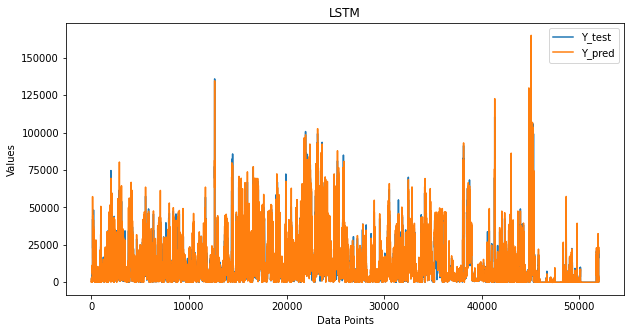

In [ ]:
fig, axes = plt.subplots(1, 1, sharex=True, sharey=True,figsize=(10,5))
ax3 = axes
ax3.plot(Y_test, label='Y_test')
ax3.plot(Y_pred, label='Y_pred')
ax3.legend(loc='best')
ax3.set_title('LSTM')
ax3.set_xlabel('Data Points')
ax3.set_ylabel('Values')
plt.show()

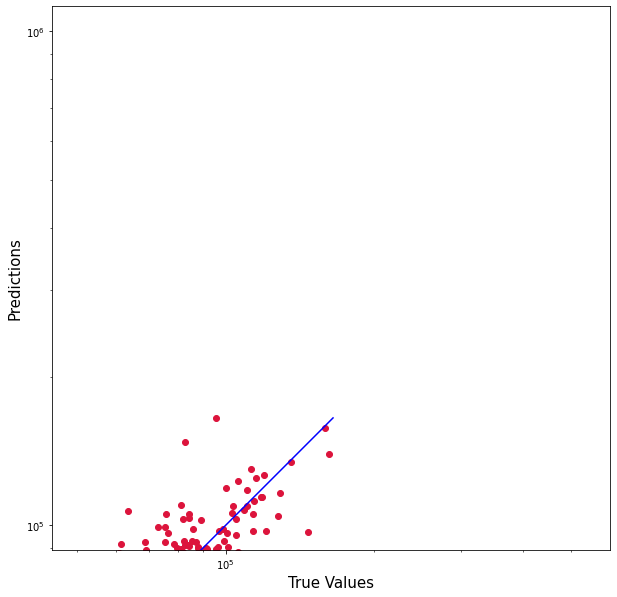

In [ ]:
plt.figure(figsize=(10,10))
plt.scatter(Y_test['DL_bitrate'], Y_pred[15], c='crimson')
plt.yscale('log')
plt.xscale('log')

p1 = max(max(Y_pred[15]), max(Y_test['DL_bitrate']))
p2 = min(min(Y_pred[15]), min(Y_test['DL_bitrate']))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

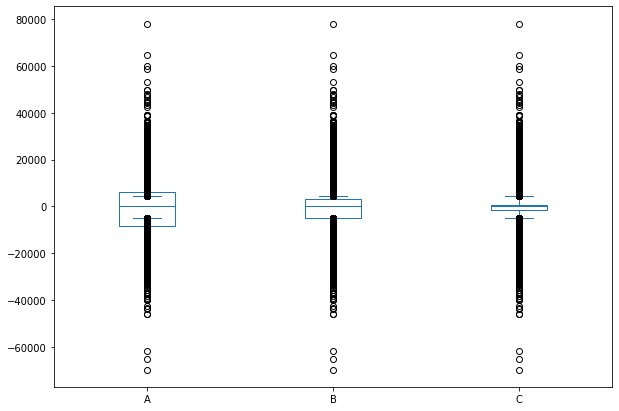

In [ ]:
import matplotlib.cbook as cbook
a=Y_test['DL_bitrate'].subtract(Y_pred[15])
stats = {}
# Compute the boxplot stats (as in the default matplotlib implementation)
stats['A'] = cbook.boxplot_stats(a, labels='A')[0]
stats['B'] = cbook.boxplot_stats(a, labels='B')[0]
stats['C'] = cbook.boxplot_stats(a, labels='C')[0]

# For box A compute the 1st and 99th percentiles
stats['A']['q1'], stats['A']['q3'] = np.percentile(a, [5, 95])
# For box B compute the 10th and 90th percentiles
stats['B']['q1'], stats['B']['q3'] = np.percentile(a, [10, 90])
# For box C compute the 25th and 75th percentiles (matplotlib default)
stats['C']['q1'], stats['C']['q3'] = np.percentile(a, [25, 75])

#fig = plt.figure(figsize =(10, 7))
fig, ax = plt.subplots(1, 1, figsize = (10,7))
# Plot boxplots from our computed statistics
bp = ax.bxp([stats['A'], stats['B'], stats['C']], positions=range(3))

# Colour the lines in the boxplot blue
for element in bp.keys():
    plt.setp(bp[element], color='C0')

In [ ]:
# calculate MAE
error = mae(Y_test, Y_pred)

# display
print("Mean absolute error : " + str(error))
print(f"Decimal Representation: {error:.20f}")

Mean absolute error : tf.Tensor(2703.146240234375, shape=(), dtype=float64)
Decimal Representation: 2703.14624023437500000000


In [ ]:
# Mean Absolute Percentage Error
error = mean_absolute_percentage_error(Y_test, Y_pred)
print(error)

print(f" {error:.5f}")

1.9525483943820264e+16
 19525483943820264.00000


In [ ]:
# Relative Absolute Error
# (|y1-y2|)/(|y1_mean-y1|)
def relative_absolute_error(y_true, y_pred):
  y1=y_true.to_numpy()
  y2=y_pred.to_numpy()
  num = np.sum(np.absolute(np.array(y1) - np.array(y2)))
  deno = np.sum(np.absolute(y2-np.mean(y1)))
  return (num/deno)
relative_absolute_error(Y_test, Y_pred)

0.2680134458550258

In [ ]:
# Root Relative Squared Error
# (|y1-y2|^2)/(|y1_mean-y1|^2)
def rrse(y_true, y_pred):
  y1=y_true.to_numpy()
  y2=y_pred.to_numpy()
  num = np.sum(np.square(np.absolute(np.array(y1) - np.array(y2))))
  deno = np.sum(np.square(np.absolute(y2-np.mean(y1))))
  return (num/deno)
rrse(Y_test, Y_pred)

0.12687401371009818

## Testing on SPlit Throughput

## Low Throughput

In [ ]:
df = frame_low_test[col_names_scaled]
df_test_scaled = pd.DataFrame(min_max_scaler.fit_transform(df))
X_test_scaled = df_test_scaled.iloc[:,:-1]
X_test_scaled.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0.616,0.571,0.429,0.429,0.429,0.068,0.028,0.000,0.000,0.000,0.635,0.635,0.645,0.623,0.597
1,0.488,0.500,0.571,0.571,0.571,0.022,0.039,0.045,0.070,0.034,0.667,0.635,0.645,0.656,0.628
2,0.488,0.429,0.429,0.429,0.571,0.035,0.060,0.017,0.028,0.055,0.603,0.603,0.613,0.623,0.612
3,0.616,0.429,0.429,0.429,0.429,0.046,0.034,0.060,0.018,0.033,0.619,0.603,0.613,0.623,0.597
4,0.616,0.571,0.571,0.429,0.429,0.025,0.037,0.045,0.036,0.075,0.635,0.619,0.629,0.623,0.597


In [ ]:
Y_test = frame_low_test.iloc[:,-1:]
Y_test.reset_index(drop=True,inplace=True)
X_pred_scaled = best_model.predict(X_test_scaled)
df_test_scaled[15]=X_pred_scaled
#Inverse Transforming the Predicted Values
df_test = pd.DataFrame(min_max_scaler.inverse_transform(df_test_scaled))
Y_pred = df_test.iloc[:,-1:]

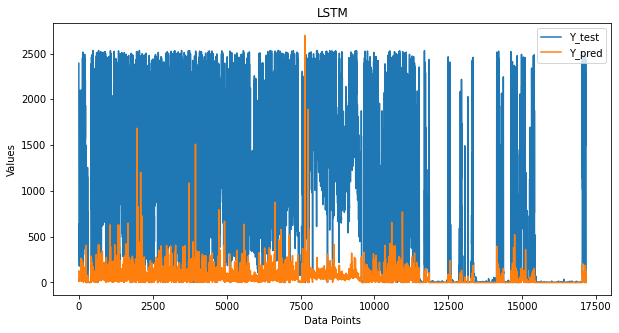

In [ ]:
fig, axes = plt.subplots(1, 1, sharex=True, sharey=True,figsize=(10,5))
ax3 = axes
ax3.plot(Y_test, label='Y_test')
ax3.plot(Y_pred, label='Y_pred')
ax3.legend(loc='best')
ax3.set_title('LSTM')
ax3.set_xlabel('Data Points')
ax3.set_ylabel('Values')
plt.show()

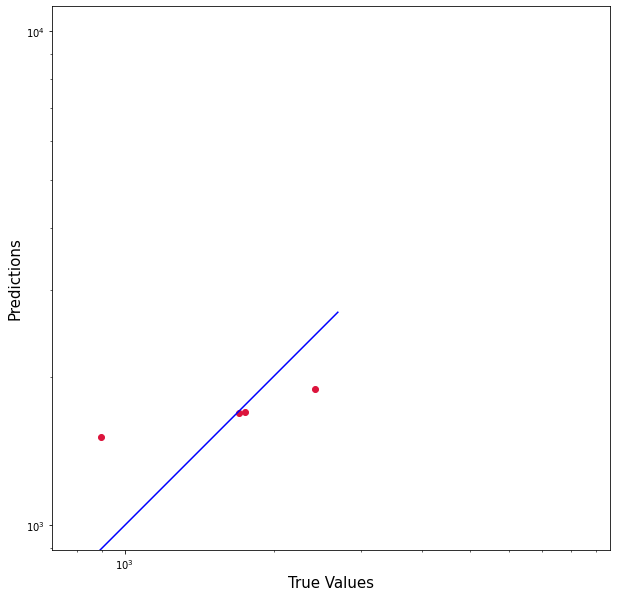

In [ ]:
plt.figure(figsize=(10,10))
plt.scatter(Y_test['DL_bitrate'], Y_pred[15], c='crimson')
plt.yscale('log')
plt.xscale('log')

p1 = max(max(Y_pred[15]), max(Y_test['DL_bitrate']))
p2 = min(min(Y_pred[15]), min(Y_test['DL_bitrate']))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

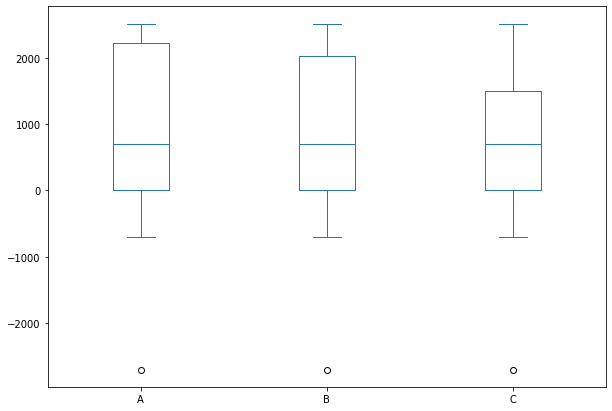

In [ ]:
import matplotlib.cbook as cbook
a=Y_test['DL_bitrate'].subtract(Y_pred[15])
stats = {}
# Compute the boxplot stats (as in the default matplotlib implementation)
stats['A'] = cbook.boxplot_stats(a, labels='A')[0]
stats['B'] = cbook.boxplot_stats(a, labels='B')[0]
stats['C'] = cbook.boxplot_stats(a, labels='C')[0]

# For box A compute the 1st and 99th percentiles
stats['A']['q1'], stats['A']['q3'] = np.percentile(a, [5, 95])
# For box B compute the 10th and 90th percentiles
stats['B']['q1'], stats['B']['q3'] = np.percentile(a, [10, 90])
# For box C compute the 25th and 75th percentiles (matplotlib default)
stats['C']['q1'], stats['C']['q3'] = np.percentile(a, [25, 75])

#fig = plt.figure(figsize =(10, 7))
fig, ax = plt.subplots(1, 1, figsize = (10,7))
# Plot boxplots from our computed statistics
bp = ax.bxp([stats['A'], stats['B'], stats['C']], positions=range(3))

# Colour the lines in the boxplot blue
for element in bp.keys():
    plt.setp(bp[element], color='C0')

In [ ]:
Y_pred

,15
0,125.421
1,77.599
2,94.033
3,116.959
4,85.467
...,...
17157,15.701
17158,0.712
17159,0.624
17160,-0.016


In [ ]:
# calculate MAE
error = mae(Y_test, Y_pred)

# display
print("Mean absolute error : " + str(error))
print(f"Decimal Representation: {error:.20f}")

Mean absolute error : tf.Tensor(833.4564208984375, shape=(), dtype=float64)
Decimal Representation: 833.45642089843750000000


In [ ]:
# Mean Absolute Percentage Error
error = mean_absolute_percentage_error(Y_test, Y_pred)
print(error)

print(f" {error:.5f}")

2389354393507914.5
 2389354393507914.50000


In [ ]:
# Relative Absolute Error
# (|y1-y2|)/(|y1_mean-y1|)
def relative_absolute_error(y_true, y_pred):
  y1=y_true.to_numpy()
  y2=y_pred.to_numpy()
  num = np.sum(np.absolute(np.array(y1) - np.array(y2)))
  deno = np.sum(np.absolute(y2-np.mean(y1)))
  return (num/deno)
relative_absolute_error(Y_test, Y_pred)

1.0013839454870548

In [ ]:
# Root Relative Squared Error
# (|y1-y2|^2)/(|y1_mean-y1|^2)
def rrse(y_true, y_pred):
  y1=y_true.to_numpy()
  y2=y_pred.to_numpy()
  num = np.sum(np.square(np.absolute(np.array(y1) - np.array(y2))))
  deno = np.sum(np.square(np.absolute(y2-np.mean(y1))))
  return (num/deno)
rrse(Y_test, Y_pred)

1.8829465845732896

## Medium Throughput

In [ ]:
df = frame_medium_test[col_names_scaled]
df_test_scaled = pd.DataFrame(min_max_scaler.fit_transform(df))
X_test_scaled = df_test_scaled.iloc[:,:-1]
X_test_scaled.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0.429,0.429,0.571,0.429,0.429,0.022,0.017,0.029,0.025,0.017,0.523,0.500,0.532,0.571,0.641
1,0.429,0.429,0.357,0.357,0.357,0.050,0.026,0.018,0.037,0.010,0.295,0.283,0.191,0.245,0.242
2,0.571,0.357,0.357,0.357,0.571,0.023,0.010,0.008,0.011,0.013,0.386,0.348,0.362,0.347,0.361
3,0.571,0.571,0.357,0.357,0.357,0.026,0.012,0.010,0.008,0.013,0.386,0.370,0.362,0.408,0.361
4,0.571,0.571,0.571,0.571,0.357,0.030,0.017,0.013,0.012,0.012,0.432,0.413,0.383,0.429,0.421


In [ ]:
Y_test = frame_medium_test.iloc[:,-1:]
Y_test.reset_index(drop=True,inplace=True)
X_pred_scaled = best_model.predict(X_test_scaled)
df_test_scaled[15]=X_pred_scaled
#Inverse Transforming the Predicted Values
df_test = pd.DataFrame(min_max_scaler.inverse_transform(df_test_scaled))
Y_pred = df_test.iloc[:,-1:]

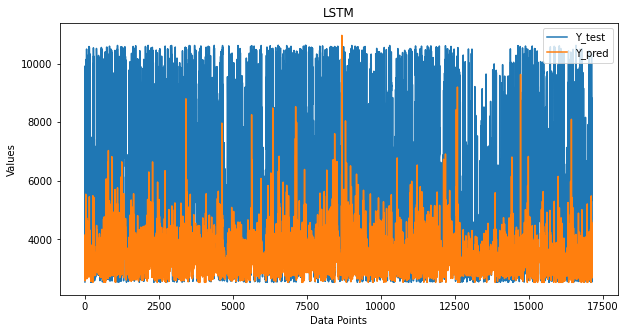

In [ ]:
fig, axes = plt.subplots(1, 1, sharex=True, sharey=True,figsize=(10,5))
ax3 = axes
ax3.plot(Y_test, label='Y_test')
ax3.plot(Y_pred, label='Y_pred')
ax3.legend(loc='best')
ax3.set_title('LSTM')
ax3.set_xlabel('Data Points')
ax3.set_ylabel('Values')
plt.show()

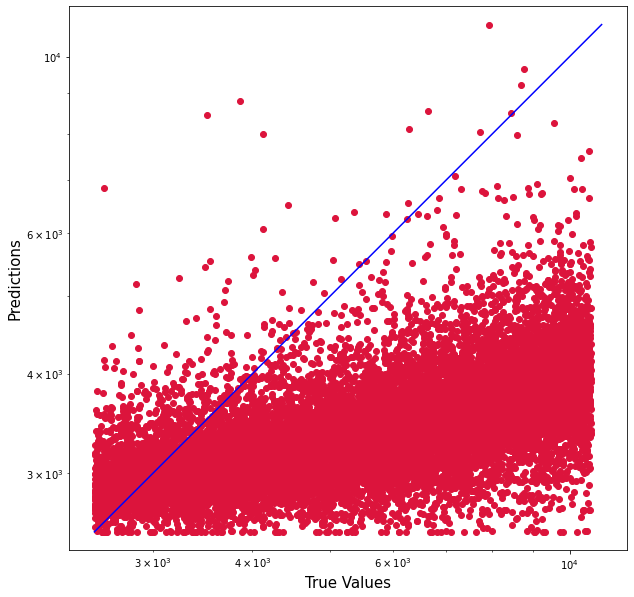

In [ ]:
plt.figure(figsize=(10,10))
plt.scatter(Y_test['DL_bitrate'], Y_pred[15], c='crimson')
plt.yscale('log')
plt.xscale('log')

p1 = max(max(Y_pred[15]), max(Y_test['DL_bitrate']))
p2 = min(min(Y_pred[15]), min(Y_test['DL_bitrate']))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

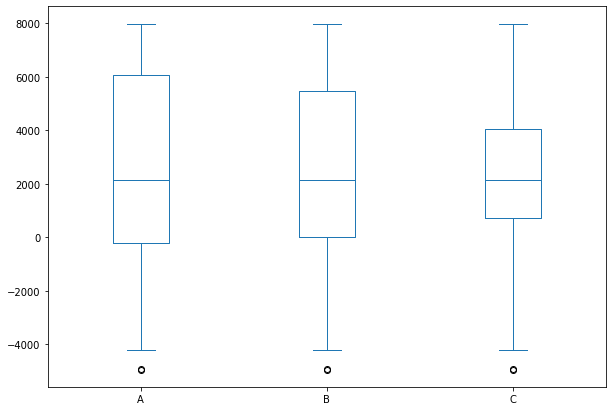

In [ ]:
import matplotlib.cbook as cbook
a=Y_test['DL_bitrate'].subtract(Y_pred[15])
stats = {}
# Compute the boxplot stats (as in the default matplotlib implementation)
stats['A'] = cbook.boxplot_stats(a, labels='A')[0]
stats['B'] = cbook.boxplot_stats(a, labels='B')[0]
stats['C'] = cbook.boxplot_stats(a, labels='C')[0]

# For box A compute the 1st and 99th percentiles
stats['A']['q1'], stats['A']['q3'] = np.percentile(a, [5, 95])
# For box B compute the 10th and 90th percentiles
stats['B']['q1'], stats['B']['q3'] = np.percentile(a, [10, 90])
# For box C compute the 25th and 75th percentiles (matplotlib default)
stats['C']['q1'], stats['C']['q3'] = np.percentile(a, [25, 75])

#fig = plt.figure(figsize =(10, 7))
fig, ax = plt.subplots(1, 1, figsize = (10,7))
# Plot boxplots from our computed statistics
bp = ax.bxp([stats['A'], stats['B'], stats['C']], positions=range(3))

# Colour the lines in the boxplot blue
for element in bp.keys():
    plt.setp(bp[element], color='C0')

In [ ]:
Y_pred

,15
0,2741.991
1,2845.340
2,2649.401
3,2681.170
4,2727.730
...,...
17148,2848.997
17149,2917.606
17150,2940.285
17151,3036.440


In [ ]:
# calculate MAE
error = mae(Y_test, Y_pred)

# display
print("Mean absolute error : " + str(error))
print(f"Decimal Representation: {error:.20f}")

Mean absolute error : tf.Tensor(2510.030029296875, shape=(), dtype=float64)
Decimal Representation: 2510.03002929687500000000


In [ ]:
# Mean Absolute Percentage Error
error = mean_absolute_percentage_error(Y_test, Y_pred)
print(error)

print(f" {error:.5f}")

0.3604577852966532
 0.36046


In [ ]:
# Relative Absolute Error
# (|y1-y2|)/(|y1_mean-y1|)
def relative_absolute_error(y_true, y_pred):
  y1=y_true.to_numpy()
  y2=y_pred.to_numpy()
  num = np.sum(np.absolute(np.array(y1) - np.array(y2)))
  deno = np.sum(np.absolute(y2-np.mean(y1)))
  return (num/deno)
relative_absolute_error(Y_test, Y_pred)

1.0206259843618062

In [ ]:
# Root Relative Squared Error
# (|y1-y2|^2)/(|y1_mean-y1|^2)
def rrse(y_true, y_pred):
  y1=y_true.to_numpy()
  y2=y_pred.to_numpy()
  num = np.sum(np.square(np.absolute(np.array(y1) - np.array(y2))))
  deno = np.sum(np.square(np.absolute(y2-np.mean(y1))))
  return (num/deno)
rrse(Y_test, Y_pred)

1.59717831340994

## High Throughput

In [ ]:
df = frame_high_test[col_names_scaled]
df_test_scaled = pd.DataFrame(min_max_scaler.fit_transform(df))
X_test_scaled = df_test_scaled.iloc[:,:-1]
X_test_scaled.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0.643,0.643,0.571,0.571,0.500,0.031,0.033,0.028,0.024,0.028,0.444,0.413,0.438,0.438,0.438
1,0.643,0.643,0.071,0.357,0.357,0.044,0.047,0.047,0.038,0.050,0.444,0.457,0.354,0.354,0.354
2,0.643,1.000,0.643,1.000,0.786,0.141,0.104,0.076,0.065,0.060,0.689,0.696,0.604,0.604,0.479
3,0.643,0.643,1.000,0.643,1.000,0.311,0.152,0.104,0.073,0.067,0.600,0.696,0.708,0.604,0.604
4,0.071,0.071,0.643,0.643,1.000,0.327,0.200,0.335,0.147,0.103,0.489,0.609,0.625,0.708,0.708


In [ ]:
Y_test = frame_high_test.iloc[:,-1:]
Y_test.reset_index(drop=True,inplace=True)
X_pred_scaled = best_model.predict(X_test_scaled)
df_test_scaled[15]=X_pred_scaled
#Inverse Transforming the Predicted Values
df_test = pd.DataFrame(min_max_scaler.inverse_transform(df_test_scaled))
Y_pred = df_test.iloc[:,-1:]

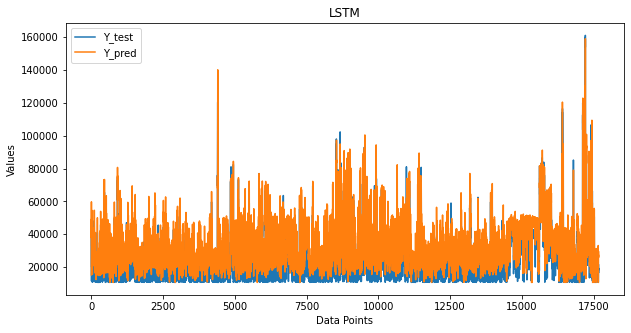

In [ ]:
fig, axes = plt.subplots(1, 1, sharex=True, sharey=True,figsize=(10,5))
ax3 = axes
ax3.plot(Y_test, label='Y_test')
ax3.plot(Y_pred, label='Y_pred')
ax3.legend(loc='best')
ax3.set_title('LSTM')
ax3.set_xlabel('Data Points')
ax3.set_ylabel('Values')
plt.show()

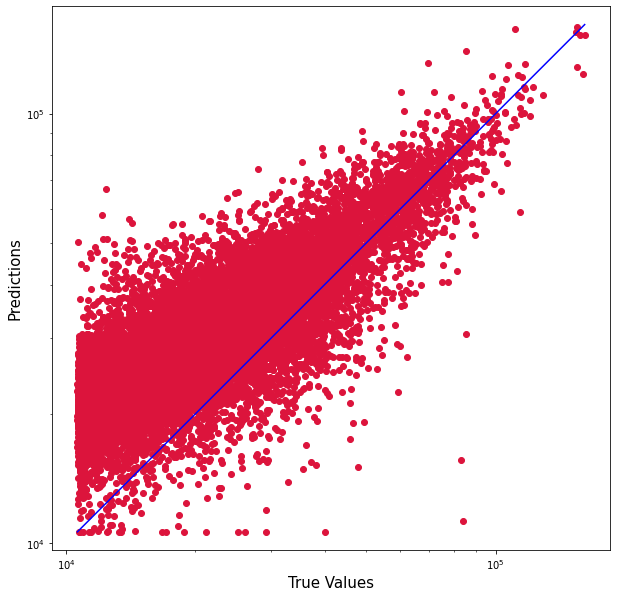

In [ ]:
plt.figure(figsize=(10,10))
plt.scatter(Y_test['DL_bitrate'], Y_pred[15], c='crimson')
plt.yscale('log')
plt.xscale('log')

p1 = max(max(Y_pred[15]), max(Y_test['DL_bitrate']))
p2 = min(min(Y_pred[15]), min(Y_test['DL_bitrate']))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

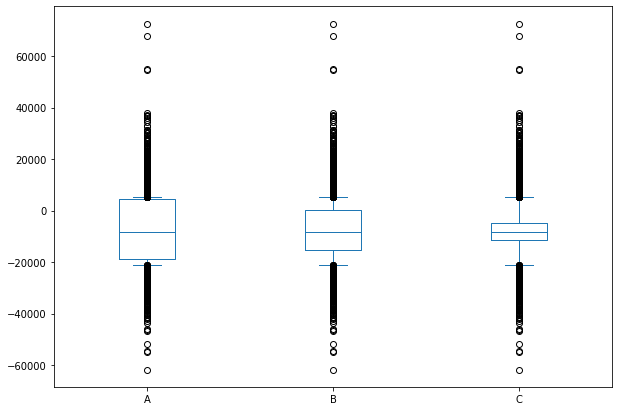

In [ ]:
import matplotlib.cbook as cbook
a=Y_test['DL_bitrate'].subtract(Y_pred[15])
stats = {}
# Compute the boxplot stats (as in the default matplotlib implementation)
stats['A'] = cbook.boxplot_stats(a, labels='A')[0]
stats['B'] = cbook.boxplot_stats(a, labels='B')[0]
stats['C'] = cbook.boxplot_stats(a, labels='C')[0]

# For box A compute the 1st and 99th percentiles
stats['A']['q1'], stats['A']['q3'] = np.percentile(a, [5, 95])
# For box B compute the 10th and 90th percentiles
stats['B']['q1'], stats['B']['q3'] = np.percentile(a, [10, 90])
# For box C compute the 25th and 75th percentiles (matplotlib default)
stats['C']['q1'], stats['C']['q3'] = np.percentile(a, [25, 75])

#fig = plt.figure(figsize =(10, 7))
fig, ax = plt.subplots(1, 1, figsize = (10,7))
# Plot boxplots from our computed statistics
bp = ax.bxp([stats['A'], stats['B'], stats['C']], positions=range(3))

# Colour the lines in the boxplot blue
for element in bp.keys():
    plt.setp(bp[element], color='C0')

In [ ]:
Y_pred

,15
0,15197.582
1,16476.796
2,32043.172
3,51135.166
4,59726.399
...,...
17672,29630.783
17673,28490.290
17674,28696.326
17675,25845.727


In [ ]:
# calculate MAE
error = mae(Y_test, Y_pred)

# display
print("Mean absolute error : " + str(error))
print(f"Decimal Representation: {error:.20f}")

Mean absolute error : tf.Tensor(9151.6923828125, shape=(), dtype=float64)
Decimal Representation: 9151.69238281250000000000


In [ ]:
# Mean Absolute Percentage Error
error = mean_absolute_percentage_error(Y_test, Y_pred)
print(error)

print(f" {error:.5f}")

0.47382469516118303
 0.47382


In [ ]:
# Relative Absolute Error
# (|y1-y2|)/(|y1_mean-y1|)
def relative_absolute_error(y_true, y_pred):
  y1=y_true.to_numpy()
  y2=y_pred.to_numpy()
  num = np.sum(np.absolute(np.array(y1) - np.array(y2)))
  deno = np.sum(np.absolute(y2-np.mean(y1)))
  return (num/deno)
relative_absolute_error(Y_test, Y_pred)

0.8729585057951352

In [ ]:
# Root Relative Squared Error
# (|y1-y2|^2)/(|y1_mean-y1|^2)
def rrse(y_true, y_pred):
  y1=y_true.to_numpy()
  y2=y_pred.to_numpy()
  num = np.sum(np.square(np.absolute(np.array(y1) - np.array(y2))))
  deno = np.sum(np.square(np.absolute(y2-np.mean(y1))))
  return (num/deno)
rrse(Y_test, Y_pred)

0.45837381499826985